# Dataset: Formspring v4
The Formspring v4 dataset consists of 12773 entries scraped from Formspring.me in Summer 2010. Entries were labelled through Amazon Mechanical Turk [[1](#amt2018)] by three annotators, each of them reporting if the entry was considered a cyberbullying trace, the word(s) or phrase(s) identified as the reason it was tagged as cyberbullying, and a severity number from 0 to 10. Because of labelling inconsistencies, the severity field has not been taken into account when evaluating the message. Also, in several instances, annotators had conflicting opinions on whether messages contained instances of cyberbullying or not. To address these labelling inconsistencies, an additional parsing method has been implemented: if the message has been flagged as containing cyberbullying by at least two of the three annotators, then it is considered a cyberbullying trace.

## Setup

The necessary modules are imported, the corpus to parse is chosen, and the logger is initialized.

In [1]:
from Classification import Benchmark, ClassifierType, MetricType, FeatureExtraction, FeatureExtractionStep
from Data import Dataset
from PreProcessing import CorpusName, CorpusParser
from Utils import Log, Time
from Utils.Log import LogOutput, LogLevel

# Select corpus name.
corpus_name = CorpusName.FORMSPRING
corpus_path = "./datasets/formspring/formspring_data.csv"

# Initialize logger.
output_path = f'./out/{Time.get_timestamp("%Y-%m-%d")}_{corpus_name}'
Log.init(path=output_path)

[2019-07-08 00:33:06] Logger initialized.


## Corpus parser and dataset container

The parser and the dataset container are initialized. 

The _democratic parsing_ method is used as discussed in [section 3.3.2](https://stefanofrazzetto.com/wp-content/uploads/2019/04/Stefano-Frazzetto-Dissertation.pdf#subsection.3.3.2) of my dissertation [[2](#frazzetto2019)].

In [2]:
parser = CorpusParser.factory(
    corpus_name=corpus_name, 
    source_path=corpus_path, 
    democratic=True,
    deserialize=True
)

dataset = Dataset(parser.get_params(), corpus_name=corpus_name)

parser.parse()
parser.log_info()

[2019-07-08 00:33:06] Deserializing FormspringParser... 
[2019-07-08 00:33:06] Done deserializing.
[2019-07-08 00:33:06] Positive: 764 - Negative: 12009 / Total: 12773


## Populating the dataset

The dataset is populated with the samples extracted using the parser.

In [3]:
parser.add_to_dataset(dataset)
dataset.finalize()
dataset.log_info()

Subset,Positive,Negative,Positive %,% of total samples
Training,650,10207,5.99,85
Testing,114,1802,5.95,15
Total,764,12009,5.98,100


## Balance subsets
Training and testing subsets are balanced with a samples ratio of 5:1 (negative samples over positives), if achievable.

In [4]:
dataset.balance_all(5)
dataset.log_info()

[2019-07-08 00:33:06] Dropping majority class samples for the training subset.
[2019-07-08 00:33:06] Dropping majority class samples for the testing subset.


Subset,Positive,Negative,Positive %,% of total samples
Training,650,3250,16.67,85.08
Testing,114,570,16.67,14.92
Total,764,3820,16.67,100


## Initialize feature extraction pipeline

The feature extraction pipeline is initialized:

The dataset is transformed into training data for the machine learning algorithms by vectorizing it, applying Term Frequency--Inverse Document Frequency (TF-IDF), and oversampling it, i.e. adding _synthetic samples_, with ADASYN. The number of features for the vectorization process is intentionally left unbounded to make use of all the features available. 

In [5]:
feature_extraction = FeatureExtraction(
    FeatureExtractionStep.TFIDF,
    FeatureExtractionStep.OVERSAMPLE_ADASYN,
    dataset=dataset,
    max_features=None,
)

[nltk_data] Downloading package punkt to /home/stefano/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[2019-07-08 00:33:07] Extracting features using the following pipeline:
[2019-07-08 00:33:07] 	- CountVectorizer
[2019-07-08 00:33:07] 	- TF-IDF
[2019-07-08 00:33:07] 	- Over-sampling with ADASYN


## Initialize classifiers
Classifiers are added to the benchmark and initialized with the data extracted using the previously created pipeline.

In [6]:
benchmark = Benchmark(dataset=dataset, feature_extraction=feature_extraction)
benchmark.add_classifier(ClassifierType.RandomForest)
benchmark.add_classifier(ClassifierType.MultiLayerPerceptron)
benchmark.add_classifier(ClassifierType.SupportVectorMachine)
benchmark.add_classifier(ClassifierType.MultinomialNaiveBayes)
benchmark.add_classifier(ClassifierType.LogisticRegression)
benchmark.initialize_classifiers()

[2019-07-08 00:33:08] Initializing classifiers...
[2019-07-08 00:33:32] Classifiers initialized correctly.


## Run benchmark

The benchmark is run on the testing subset. This subset is split into five smaller subsets.

To generate the evaluation metrics, the testing is split into five smaller subsets, and classifiers are evaluated on each of them. This is done to create a more balanced estimate of the results.


In [7]:
benchmark.run(5)

[2019-07-08 00:33:32] Starting benchmarking process.
[2019-07-08 00:33:33] Benchmark process completed.


## Plots

The results obtained are finally plotted. As it can be seen from the graphic below, the Logistic Regression (LR) algorithm produced the highest results for the Matthews Correlation Coefficient, reaching a median value of approximately 0.7.


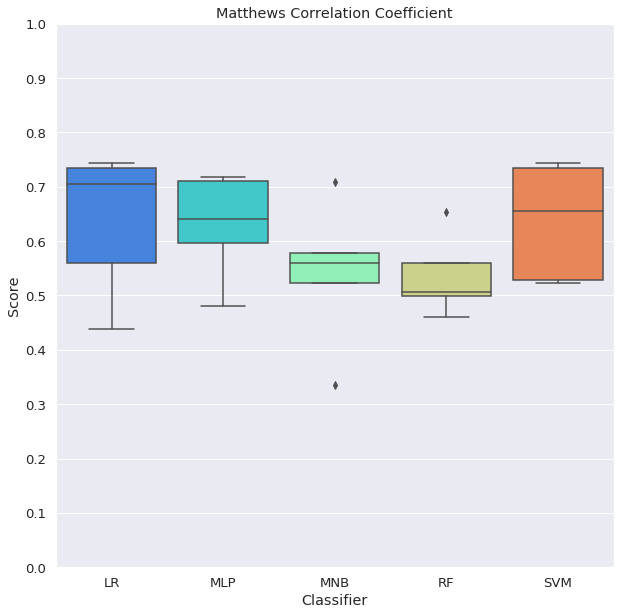

In [9]:
benchmark.plot_metrics(MetricType.MCC)

# Bibliography

<a id="amt2018">1.</a> Amazon Mechanical Turk Inc., 2018. [Online]. Available: https://www.mturk.com/.

<a id="frazzetto2019">2.</a> S. Frazzetto, "Automated Crime Detection and Classification in Online Chats using Machine Learning", May 2019. \[Online\]. Available: https://stefanofrazzetto.com/dissertation/